In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

2025-04-08 00:09:54.942872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744088995.871898     584 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744088996.067750     584 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744088997.809506     584 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744088997.809534     584 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744088997.809536     584 computation_placer.cc:177] computation placer alr

In [2]:
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
class CustomModel:
    def __init__(self, n, k, max_m_value):
        self.n = n
        self.k = k
        self.max_m_value = max_m_value

        self.P_matrices = None
        self.m_heights = None
        self.P_matrices_train = None
        self.P_matrices_test = None
        self.P_matrices_val = None
        self.m_heights_train = None
        self.m_heights_test = None
        self.m_heights_log_train = None
        self.m_heights_log_test = None
        self.m_heights_log_val = None
        self.eval_inputs = None
        self.eval_outputs = None
        self.P_matrices_train_aug = None
        self.m_heights_log_train_aug = None

        self.train_dataset = None
        self.val_dataset = None

        self.model_name = f'model_{self.n}_{self.k}.keras'
        self.model = None
        self.history = None
    def load_and_preprocess_data(self,filepath):
        with gzip.open(filepath, 'rb') as f:
            dataset = pickle.load(f)

        self.P_matrices = []
        self.m_heights = []

        for row in dataset:
            # Remove the last `inf`, this is an error due to bug in the dataset generation
            heights = row['m_heights'][:self.max_m_value]
            if len(heights) != self.max_m_value:
                continue
            if any(h == float('inf') or h <= 0 for h in heights):
                continue
            # Convert m-heights to log scale
            log_heights = np.log(heights)
            P_matrix = np.array(row['P_matrix'], dtype=np.float32)

            self.P_matrices.append(P_matrix)
            # m_heights.append(log_heights)
            self.m_heights.append(heights)
        self.P_matrices = np.array(self.P_matrices, dtype=np.float32)
        self.m_heights = np.array(self.m_heights, dtype=np.float32)
        print("P_matrices shape:", self.P_matrices.shape)
        print("m_heights shape:", self.m_heights.shape)
        # pritnt range of all m-heights
        print("Range of log m_heights:")
        print("Min:", np.min(self.m_heights, axis=0))
        print("Max:", np.max(self.m_heights, axis=0))

    def generate_permuted_dataset(self, P_matrices, m_heights, num_permutations=3):
        """Create augmented dataset by permuting columns of P_matrices."""
        augmented_P_matrices = []
        augmented_m_heights = []

        for i in range(len(P_matrices)):
            original = P_matrices[i]
            target = m_heights[i]

            # Keep original
            augmented_P_matrices.append(original)
            augmented_m_heights.append(target)

            # Generate random permutations
            for _ in range(num_permutations):
                permuted = original[:, np.random.permutation(original.shape[1])]
                augmented_P_matrices.append(permuted)
                augmented_m_heights.append(target)
        return np.array(augmented_P_matrices), np.array(augmented_m_heights)
    def train_test_val_split(self, val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342):

        if(self.P_matrices is None or self.m_heights is None):
            raise ValueError("Data not loaded. Please load the data first.")
        # Train-test split
        self.P_matrices_train, self.P_matrices_test,\
              self.m_heights_train, self.m_heights_test\
                 = train_test_split(self.P_matrices, self.m_heights, test_size=test_split, random_state=random_state)

        # Converting test set to evaluator format
        self.eval_inputs = {}
        self.eval_outputs = {}

        # Iterate through each P_matrix and corresponding m_heights in test_dataset
        for i in range(len(self.P_matrices_test)):
            P_matrix = self.P_matrices_test[i]
            m_heights_list = self.m_heights_test[i]
            for m in range(2, self.max_m_value + 1):  # m ranges from 2 to max_m_value
                key = f"[{self.n},{self.k},{m}]"

                # Add the P_matrix to the inputs dictionary
                if key not in self.eval_inputs:
                    self.eval_inputs[key] = []
                self.eval_inputs[key].append(P_matrix)

                # Add the corresponding m_height to the outputs dictionary
                if key not in self.eval_outputs:
                    self.eval_outputs[key] = []
                self.eval_outputs[key].append(m_heights_list[m - 1])  # m-1 to get the correct index

        # Change m_heights_train and m_heights_test to log_scale
        self.m_heights_log_train = np.log(self.m_heights_train)
        self.m_heights_log_test = np.log(self.m_heights_test)

        # Train-validation split
        self.P_matrices_train, self.P_matrices_val, self.m_heights_log_train, self.m_heights_log_val = train_test_split(self.P_matrices_train, self.m_heights_log_train, test_size=val_split, random_state=random_state)
        # Generate augmented  training dataset
        self.P_matrices_train_aug, self.m_heights_log_train_aug = self.generate_permuted_dataset(self.P_matrices_train, self.m_heights_log_train, num_permutations=num_permutations)
        # Create TensorFlow datasets
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_train_aug, self.m_heights_log_train_aug))
        self.train_dataset = self.train_dataset.shuffle(self.P_matrices_train_aug.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_val, self.m_heights_log_val))
        self.val_dataset = self.val_dataset.shuffle(self.P_matrices_val.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        print("Train dataset shape:", self.P_matrices_train_aug.shape, self.m_heights_log_train_aug.shape)
        print("Validation dataset shape:", self.P_matrices_val.shape, self.m_heights_log_val.shape)
        print("Test dataset shape:", self.P_matrices_test.shape, self.m_heights_log_test.shape)

    def model_compile(self, build_model, print_summary=False):
        if self.train_dataset is None or self.val_dataset is None:
            raise ValueError("Train and validation datasets not created. Please create them first.")
        self.model = build_model(self.n, self.k, self.max_m_value)
        print("Model compiled.")
        if print_summary:
            self.model.summary()

    def model_train(self, epochs=10, verbose=0, patience=5 , model_save_directory="."):
        if self.model is None:
            raise ValueError("Model not built. Please build the model first.")

        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_directory + '/' + self.model_name, save_best_only=True)
        # Train the model
        self.history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=[
                early_stopping,
                model_checkpoint,
            ],
            verbose=verbose
        )
    def plot_history(self):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        history_dict = self.history.history
        mse = history_dict["loss"]
        val_mse = history_dict["val_loss"]
        epochs = range(1, len(mse) + 1)
        print('Train MSE :', mse)
        print('Validation MSE :', val_mse)
        plt.plot(epochs, mse, "bo", label="Training mse")
        plt.plot(epochs, val_mse, "b", label="Validation mse")
        plt.title("Training and validation mean squared error")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()
    def evaluate_model(self, batch_size=128):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        results = self.model.evaluate(self.P_matrices_test, self.m_heights_log_test, batch_size=batch_size, verbose=0)
        print('Best model loss :', results)

In [6]:
models_dict =  {
    "model_1": {'n': 9, 'k': 4, 'max_m_value': 5, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_2": {'n': 9, 'k': 5, 'max_m_value': 4, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},
    "model_3": {'n': 9, 'k': 6, 'max_m_value': 3, 'model': None, 'file_name': "G_9_6_maxM3.pklgz"},
    "model_4": {'n': 10, 'k': 4, 'max_m_value': 6, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_5": {'n': 10, 'k': 5, 'max_m_value': 5, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_6": {'n': 10, 'k': 6, 'max_m_value': 4, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},
}
import gc
gc.collect()

179

In [7]:
def build_model(n, k, max_m_value):
    input_shape = (k, n - k)  
    
    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Transpose so we can treat each column independently
    # After transpose: shape becomes (batch_size, n-k, k)
    transposed = layers.Permute((2, 1))(input_layer)  

    # Shared MLP applied to each column (like DeepSets)
    shared_mlp = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu')
    ])

    # Apply shared MLP to each column (TimeDistributed over n-k columns)
    encoded_columns = layers.TimeDistributed(shared_mlp)(transposed)  # (batch, n-k, 64)

    # Aggregate over columns to achieve permutation invariance
    aggregated = layers.GlobalAveragePooling1D()(encoded_columns)  # (batch, 64)

    # Final prediction head
    output_layer = layers.Dense(max_m_value, activation='linear')(aggregated)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model

In [8]:
import os
os.chdir("/mnt/d/MS/deep_learning/m_height_prediction")
samples_filepath = "/mnt/d/MS/deep_learning/m_height_prediction/samples_combined/"

Loading data for model_9_4...
P_matrices shape: (34999, 4, 5)
m_heights shape: (34999, 5)
Range of log m_heights:
Min: [   3.3710756    8.660064    75.08341    182.32542   1253.2301   ]
Max: [2.7675543e+02 7.5315314e+02 4.8695015e+03 2.2775238e+05 7.9118080e+08]
Generating dataset for model_9_4...


I0000 00:00:1744089039.401688     584 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Train dataset shape: (134394, 4, 5) (134394, 5)
Validation dataset shape: (5600, 4, 5) (5600, 5)
Test dataset shape: (7000, 4, 5) (7000, 5)
Compiling model for model_9_4...
Model compiled.
Training model for model_9_4...


I0000 00:00:1744089047.715658     669 service.cc:152] XLA service 0x7f1cd0007f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744089047.715705     669 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-08 00:10:48.312412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744089049.157739     669 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744089051.849287     669 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Evaluating model for model_9_4...
Train MSE : [2.3080501556396484, 0.9153764247894287, 0.8001657128334045]
Validation MSE : [1.0117524862289429, 0.8604506254196167, 0.7512294054031372]


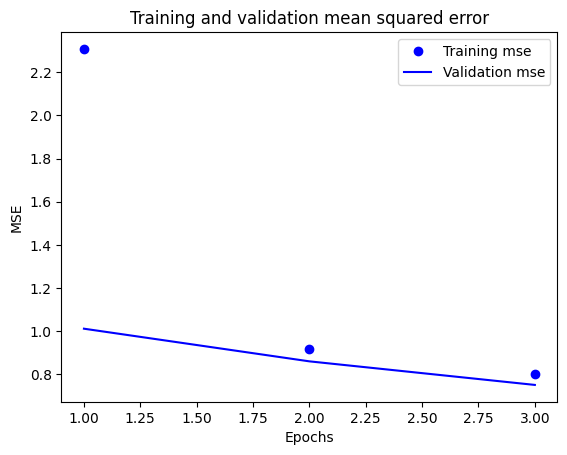

Best model loss : 0.7428287267684937
Done with model_9_4.
-----------------------------------------------------
Loading data for model_9_5...
P_matrices shape: (59992, 5, 4)
m_heights shape: (59992, 4)
Range of log m_heights:
Min: [   6.3078012   59.612354   217.01117   1291.7003   ]
Max: [4.2418826e+02 5.4309243e+03 4.0550069e+05 2.9340678e+08]
Generating dataset for model_9_5...
Train dataset shape: (230364, 5, 4) (230364, 4)
Validation dataset shape: (9599, 5, 4) (9599, 4)
Test dataset shape: (11999, 5, 4) (11999, 4)
Compiling model for model_9_5...
Model compiled.
Training model for model_9_5...
Evaluating model for model_9_5...
Train MSE : [2.852949619293213, 0.9213252067565918, 0.7498171925544739]
Validation MSE : [1.0325576066970825, 0.802617609500885, 0.6800034642219543]


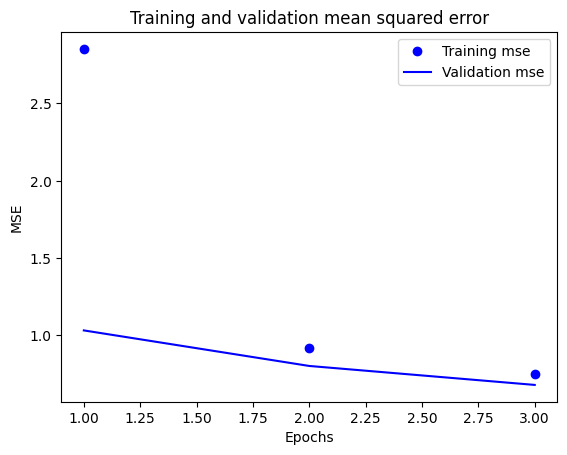

Best model loss : 0.6798571348190308
Done with model_9_5.
-----------------------------------------------------
Loading data for model_9_6...
P_matrices shape: (59998, 6, 3)
m_heights shape: (59998, 3)
Range of log m_heights:
Min: [ 30.234015 179.31691  797.8311  ]
Max: [5.184621e+02 7.401902e+04 3.043078e+08]
Generating dataset for model_9_6...
Train dataset shape: (230388, 6, 3) (230388, 3)
Validation dataset shape: (9600, 6, 3) (9600, 3)
Test dataset shape: (12000, 6, 3) (12000, 3)
Compiling model for model_9_6...
Model compiled.
Training model for model_9_6...
Evaluating model for model_9_6...
Train MSE : [2.0926403999328613, 0.937863826751709, 0.7739967703819275]
Validation MSE : [1.1256123781204224, 0.855590283870697, 0.7554075717926025]


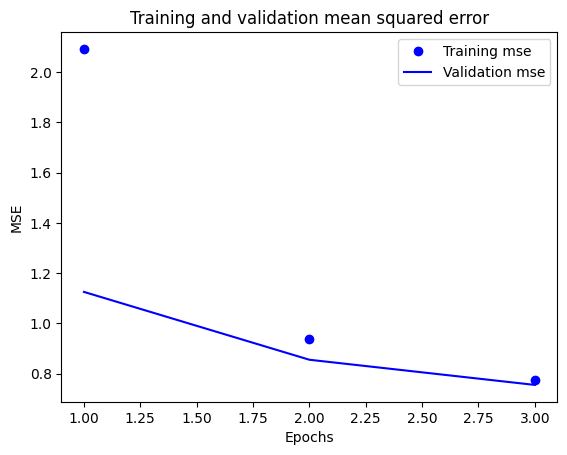

Best model loss : 0.7148546576499939
Done with model_9_6.
-----------------------------------------------------
Loading data for model_10_4...
P_matrices shape: (34999, 4, 6)
m_heights shape: (34999, 6)
Range of log m_heights:
Min: [   2.600804    7.893224   43.2334    124.328674  241.41588  1932.9349  ]
Max: [1.9218018e+02 2.9002396e+02 1.3718380e+03 8.4791533e+03 2.5119502e+05
 6.0206176e+08]
Generating dataset for model_10_4...
Train dataset shape: (134394, 4, 6) (134394, 6)
Validation dataset shape: (5600, 4, 6) (5600, 6)
Test dataset shape: (7000, 4, 6) (7000, 6)
Compiling model for model_10_4...
Model compiled.
Training model for model_10_4...
Evaluating model for model_10_4...
Train MSE : [2.280702590942383, 0.7838755249977112, 0.6974548697471619]
Validation MSE : [0.8527032732963562, 0.762381911277771, 0.6775571703910828]


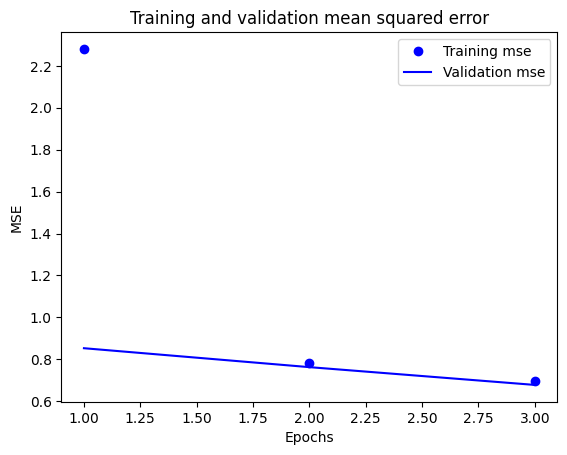

Best model loss : 0.6694655418395996
Done with model_10_4.
-----------------------------------------------------
Loading data for model_10_5...
P_matrices shape: (34996, 5, 5)
m_heights shape: (34996, 5)
Range of log m_heights:
Min: [   5.340439   45.804024  135.14496   346.75046  3788.6633  ]
Max: [3.7719022e+02 1.4024301e+03 1.5339225e+04 6.0528188e+05 2.2121303e+09]
Generating dataset for model_10_5...
Train dataset shape: (134376, 5, 5) (134376, 5)
Validation dataset shape: (5600, 5, 5) (5600, 5)
Test dataset shape: (7000, 5, 5) (7000, 5)
Compiling model for model_10_5...
Model compiled.
Training model for model_10_5...
Evaluating model for model_10_5...
Train MSE : [1.7462224960327148, 0.8787733912467957, 0.7484520077705383]
Validation MSE : [0.9922864437103271, 0.8183878064155579, 0.716294527053833]


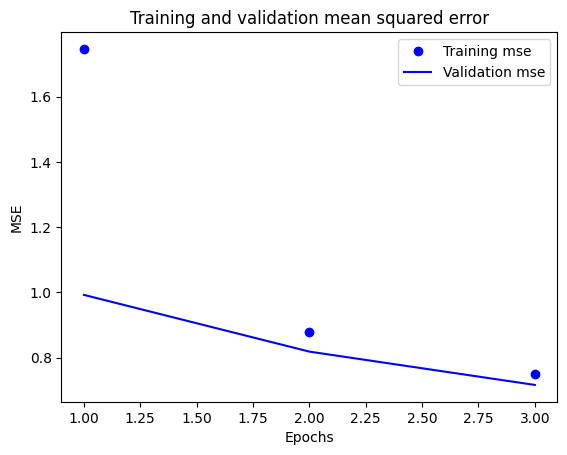

Best model loss : 0.7144674062728882
Done with model_10_5.
-----------------------------------------------------
Loading data for model_10_6...
P_matrices shape: (34993, 6, 4)
m_heights shape: (34993, 4)
Range of log m_heights:
Min: [  19.954166  121.08272   301.86646  2049.033   ]
Max: [4.8236990e+02 8.1763545e+03 3.6380481e+05 1.4934546e+08]
Generating dataset for model_10_6...
Train dataset shape: (134370, 6, 4) (134370, 4)
Validation dataset shape: (5599, 6, 4) (5599, 4)
Test dataset shape: (6999, 6, 4) (6999, 4)
Compiling model for model_10_6...
Model compiled.
Training model for model_10_6...
Evaluating model for model_10_6...
Train MSE : [3.733015298843384, 1.100187063217163, 0.9287784695625305]
Validation MSE : [1.2644163370132446, 1.03413987159729, 0.937445342540741]


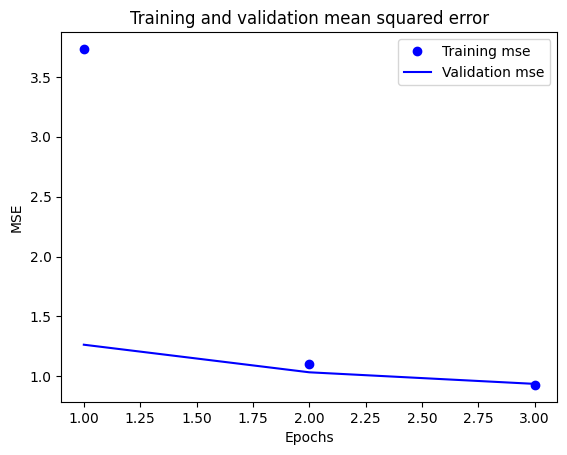

Best model loss : 0.8886277079582214
Done with model_10_6.
-----------------------------------------------------


In [9]:
from tensorflow.keras.utils import plot_model
model_save_directory = "model_0"
val_split = 0.2
test_split = 0.2
num_permutations = 5
batch_size = 128
random_state = 2342
epochs = 3
patience = 5
train_verbosity = 0
for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    filepath = samples_filepath + model_info['file_name']
    n = model_info['n']
    k = model_info['k']
    max_m_value = model_info['max_m_value']
    model_info['model'] = CustomModel(n=n, k=k, max_m_value=max_m_value)
    print(f"Loading data for model_{n}_{k}...")
    model_info['model'].load_and_preprocess_data(filepath)
    print(f"Generating dataset for model_{n}_{k}...")
    model_info['model'].train_test_val_split(val_split=val_split, test_split=test_split, num_permutations=num_permutations, batch_size=batch_size, random_state=random_state)
    print(f"Compiling model for model_{n}_{k}...")
    model_info['model'].model_compile(build_model, print_summary=False)
    plot_model(model_info['model'].model, show_shapes=True, show_layer_names=True)
    print(f"Training model for model_{n}_{k}...")
    model_info['model'].model_train(epochs=epochs, verbose=train_verbosity, patience=patience, model_save_directory = model_save_directory)
    print(f"Evaluating model for model_{n}_{k}...")
    model_info['model'].plot_history()
    model_info['model'].evaluate_model(batch_size=batch_size)
    print(f"Done with model_{n}_{k}.")
    print("-----------------------------------------------------")

eval_inputs_combined = {}
eval_outputs_combined = {}

for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    for key in model_info['model'].eval_inputs.keys():
        if key not in eval_inputs_combined:
            eval_inputs_combined[key] = []
        eval_inputs_combined[key].extend(model_info['model'].eval_inputs[key])
    for key in model_info['model'].eval_outputs.keys():
        if key not in eval_outputs_combined:
            eval_outputs_combined[key] = []
        eval_outputs_combined[key].extend(model_info['model'].eval_outputs[key])

with gzip.open(model_save_directory+'/eval_inputs_combined', 'wb') as f:
            pickle.dump(eval_inputs_combined, f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'wb') as f:
            pickle.dump(eval_outputs_combined, f)


In [4]:
from tamu_csce_636_project1 import Evaluator
evaluator = Evaluator(
    first_name="Your Name",
    last_name="Your Name",
    email="email@tamu.edu",
    print=False,
)

In [12]:
def predict_and_evaluate(n,k,m,P_matrices):
    ## load model
    model_name = model_save_directory + '/' + f'model_{n}_{k}.keras'
    model = tf.keras.models.load_model(model_name)
    m_heights = []
    P_matrices = np.array(P_matrices, dtype=np.float32)
    m_heights_pred = model.predict(P_matrices.reshape(len(P_matrices), k, n-k), verbose=0)
    m_heights =[np.exp(m_heights_pred[i][m-1]) for i in range(len(P_matrices))]
    # print(P_matrices[0])
    # print(m_heights_pred[0])
    # print(m_heights_pred[0][m-1])
    # print(np.exp(m_heights_pred[0][m-1]))
    # print(m_heights[0])
    return m_heights

In [13]:
model_save_directory = "model_0"
with gzip.open(model_save_directory+'/eval_inputs_combined', 'rb') as f:
    eval_inputs_combined = pickle.load(f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'rb') as f:
    eval_outputs_combined = pickle.load(f)
σ = evaluator.eval(
        inputs=eval_inputs_combined,
        outputs=eval_outputs_combined,
        func=predict_and_evaluate,
    )
average_σ = sum(σ.values()) / len(σ) if σ else 0
print(f"Average σ: {average_σ}")
for key, value in σ.items():
    print(f"{key}, σ: {value}")

Average σ: 1.7436323478565778
(9, 4, 2), σ: 0.3820073430611279
(9, 4, 3), σ: 0.5164314688970754
(9, 4, 4), σ: 1.162122797359915
(9, 4, 5), σ: 4.135000612660233
(9, 5, 2), σ: 0.4783191765795608
(9, 5, 3), σ: 0.9893721369874744
(9, 5, 4), σ: 3.806234990392301
(9, 6, 2), σ: 0.7394429274356377
(9, 6, 3), σ: 3.5188760479906396
(10, 4, 2), σ: 1.0771275748473295
(10, 4, 3), σ: 0.2746096401413545
(10, 4, 4), σ: 0.6122313425383292
(10, 4, 5), σ: 1.2963223084534592
(10, 4, 6), σ: 4.233401986926904
(10, 5, 2), σ: 0.3042848202809071
(10, 5, 3), σ: 0.5801003252210686
(10, 5, 4), σ: 1.2758655255584317
(10, 5, 5), σ: 4.335839721997496
(10, 6, 2), σ: 0.813799186961932
(10, 6, 3), σ: 1.4507898675723192
(10, 6, 4), σ: 4.634099503124636
